# ENSF 544 Final Project: Stock Price Prediction Using ML

### Project Group:

Tyler Chan (30068334)

Stalin D'Cunha (30062947)

For this final project, we will be using various models to predict Apple (AAPL) stock data.

Unfortunately, Scikit-learn does not have LSTM, so we will go with the following strategies:
1. Linear Regression
2. Multi Layer Perceptron
3. SVM, specifically SVR

Our dataset came from [Kaggle](https://www.kaggle.com/datasets/camnugent/sandp500). We specifically downloaded the AAPL dataset.

In [287]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

# help us view progress of parallel processes
from tqdm.notebook import tqdm
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed, parallel_backend


In [255]:
RANDOM_STATE = 0

First, read in the data and ensure no null values were read in.

In [256]:
df = pd.read_csv('AAPL_data.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [257]:
df.isna().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [258]:
df.dtypes


date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
Name       object
dtype: object

The name column is irrelevant, so we will drop it (we are looking only at one stock)

In [259]:
df.drop(columns=['Name'], inplace=True)

We need to deal with the date column. Since we are dealing with time series data, we may get temporal patterns out of them. We will use a technique called "cyclic feature encoding". This is useful since time data is cyclical: months roll over, time rolls over, etc. All code references are listed in the reference section.

In [260]:
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

df.drop(columns=['date'], inplace=True)

df.dtypes

open      float64
high      float64
low       float64
close     float64
volume      int64
day         int32
month       int32
year        int32
dtype: object

In [261]:
# helper function to create cyclical data about our dates. max=max number of 'things' in the date type. ie, a week has at max 7 days. a year has at max 12 months
def encodeCyclicalData(df, dateType, max):
    column_sin = dateType + '_sin'
    column_cos = dateType + '_cos'

    df[column_sin] = np.sin(2 * np.pi * df[dateType] / max)
    df[column_cos] = np.cos(2 * np.pi * df[dateType] / max)

    df.drop(columns=[dateType], inplace=True)
    
    return df


In [262]:
df = encodeCyclicalData(df=df, dateType='day', max=7)
df = encodeCyclicalData(df=df, dateType='month', max=12)
# years are not cyclical

In [263]:
df.head()

,open,high,low,close,volume,year,day_sin,day_cos,month_sin,month_cos
0,67.7142,68.4014,66.8928,67.8542,158168416,2013,-0.433884,-0.900969,0.866025,0.5
1,68.0714,69.2771,67.6071,68.5614,129029425,2013,0.000000,1.000000,0.866025,0.5
2,68.5014,68.9114,66.8205,66.8428,151829363,2013,0.781831,0.623490,0.866025,0.5
3,66.7442,67.6628,66.1742,66.7156,118721995,2013,0.974928,-0.222521,0.866025,0.5
4,66.3599,67.3771,66.2885,66.6556,88809154,2013,0.433884,-0.900969,0.866025,0.5


Now, we want to have lagging data for this. Basically, instead of a row containing a day's data, we will have the target, and the previous day's data (or several in this case).
Since we are greedy, we will predict the high of the target day. Again, all sourced code is cited.

In [264]:
lagged_days = 3
for i in range(1, lagged_days + 1):
    df[f'open_-{i}_days'] = df['open'].shift(i)
    df[f'high_-{i}_days'] = df['high'].shift(i)
    df[f'low_-{i}_days'] = df['low'].shift(i)
    df[f'close_-{i}_days'] = df['close'].shift(i)
    df[f'volume_-{i}_days'] = df['volume'].shift(i)

df.dropna(inplace=True)

# we only want historical data, so current data really doesn't help much. We do want current day's high though.
columns_to_drop = ['open', 'low', 'close', 'volume']
df.drop(columns=columns_to_drop, inplace=True)


In [265]:
df.head()

,high,year,day_sin,day_cos,month_sin,month_cos,open_-1_days,high_-1_days,low_-1_days,close_-1_days,...,open_-2_days,high_-2_days,low_-2_days,close_-2_days,volume_-2_days,open_-3_days,high_-3_days,low_-3_days,close_-3_days,volume_-3_days
3,67.6628,2013,0.974928,-0.222521,0.866025,0.5,68.5014,68.9114,66.8205,66.8428,...,68.0714,69.2771,67.6071,68.5614,129029425.0,67.7142,68.4014,66.8928,67.8542,158168416.0
4,67.3771,2013,0.433884,-0.900969,0.866025,0.5,66.7442,67.6628,66.1742,66.7156,...,68.5014,68.9114,66.8205,66.8428,151829363.0,68.0714,69.2771,67.6071,68.5614,129029425.0
5,67.1656,2013,-0.433884,-0.900969,0.866025,0.5,66.3599,67.3771,66.2885,66.6556,...,66.7442,67.6628,66.1742,66.7156,118721995.0,68.5014,68.9114,66.8205,66.8428,151829363.0
6,66.1042,2013,0.781831,0.623490,0.866025,0.5,66.9785,67.1656,65.7028,65.7371,...,66.3599,67.3771,66.2885,66.6556,88809154.0,66.7442,67.6628,66.1742,66.7156,118721995.0
7,65.3842,2013,0.974928,-0.222521,0.866025,0.5,65.8714,66.1042,64.8356,65.7128,...,66.9785,67.1656,65.7028,65.7371,97924631.0,66.3599,67.3771,66.2885,66.6556,88809154.0


Now, let's create the training and testing sets.

In [266]:
features = list(df.columns)
features.remove('high')

target = 'high'

X = df[features]
y = df[target]

print(X.shape)
print(y.shape)

(1256, 20)
(1256,)


In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

We decided to use gridsearch to find the best of the 3 proposed techniques.
Robust scaler is used since it handles outliers better, and stock data will likely have outliers.

In [268]:
pipeline_lrg = Pipeline([
    ('scaler', RobustScaler()),
    ('lrg', LinearRegression()),
])

pipeline_mlr = Pipeline([
    ('scaler', RobustScaler()),
    ('mlr', MLPRegressor(max_iter=500, early_stopping=True, random_state=RANDOM_STATE)),
])

pipeline_svr = Pipeline([
    ('scaler', RobustScaler()),
    ('svr', SVR(max_iter=500)),  
])

alpha_params = list(np.logspace(-4, 2, 7))

gamma_range = np.logspace(-9, 3, 13)
gamma_params = gamma_range.tolist()
gamma_params.append('scale')
gamma_params.append('auto')

param_grid_lrg = {
    'lrg__fit_intercept': [True, False],
}

param_grid_mlr = {
    'mlr__hidden_layer_sizes': [1, 10, 100],
    'mlr__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'mlr__solver': ['sgd', 'adam'],
    'mlr__alpha': alpha_params,
}

param_grid_svr = {
    'svr__C': [0.1, 0.5, 1.0, 10.0, 100.0],
    'svr__gamma': gamma_params,
    'svr__kernel': ['linear', 'poly', 'rbf']
}

scoring = {
    'r2': make_scorer(r2_score),
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
}



In [269]:

grid_search_lrg = GridSearchCV(estimator=pipeline_lrg, param_grid=param_grid_lrg, cv=5, scoring=scoring, refit='r2', verbose=3, n_jobs=-1, return_train_score=True)
grid_search_lrg.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('lrg', LinearRegression())]),
             n_jobs=-1, param_grid={'lrg__fit_intercept': [True, False]},
             refit='r2', return_train_score=True,
             scoring={'mae': make_scorer(mean_absolute_error),
                      'mse': make_scorer(mean_squared_error),
                      'r2': make_scorer(r2_score)},
             verbose=3)

In [270]:
grid_search_mlr = GridSearchCV(estimator=pipeline_mlr, param_grid=param_grid_mlr, cv=5, scoring=scoring, refit='r2', verbose=3, n_jobs=-1, return_train_score=True)
grid_search_mlr.fit(X_train, y_train)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('mlr',
                                        MLPRegressor(early_stopping=True,
                                                     max_iter=500,
                                                     random_state=0))]),
             n_jobs=-1,
             param_grid={'mlr__activation': ['identity', 'logistic', 'tanh',
                                             'relu'],
                         'mlr__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                        100.0],
                         'mlr__hidden_layer_sizes': [1, 10, 100],
                         'mlr__solver': ['sgd', 'adam']},
             refit='r2', return_train_score=True,
             scoring={'mae': make_scorer(mean_absolute_error),
                      'mse': make_scorer(mean_squared_error),
                      'r2': make_scorer(r2_score)},
             verbose=3)

In [271]:
grid_search_svr = GridSearchCV(estimator=pipeline_svr, param_grid=param_grid_svr, cv=5, scoring=scoring, refit='r2', verbose=3, n_jobs=-1, return_train_score=True)
grid_search_svr.fit(X_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


c:\Users\Tyler\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('svr', SVR(max_iter=500))]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 0.5, 1.0, 10.0, 100.0],
                         'svr__gamma': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                        0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                        100.0, 1000.0, 'scale', 'auto'],
                         'svr__kernel': ['linear', 'poly', 'rbf']},
             refit='r2', return_train_score=True,
             scoring={'mae': make_scorer(mean_absolute_error),
                      'mse': make_scorer(mean_squared_error),
                      'r2': make_scorer(r2_score)},
             verbose=3)

Above, some grid searches failed to find convergence and finished prematurely. That is ok, as long as we get one set of parameters that fit the data well.

In [293]:
lrg_train_r2 = grid_search_lrg.cv_results_['mean_train_r2'][grid_search_lrg.best_index_]
lrg_test_r2 = grid_search_lrg.best_score_
lrg_train_rmse = math.sqrt(grid_search_lrg.cv_results_['mean_train_mse'][grid_search_lrg.best_index_])
lrg_test_rmse = math.sqrt(grid_search_lrg.cv_results_['mean_test_mse'][grid_search_lrg.best_index_])
lrg_train_mae = grid_search_lrg.cv_results_['mean_train_mae'][grid_search_lrg.best_index_]
lrg_test_mae = grid_search_lrg.cv_results_['mean_test_mae'][grid_search_lrg.best_index_]

print('Linear Regression Results')
print('-------------------------------------')

print('Best Training R2 Score:', lrg_train_r2)
print('Best Testing R2 Score:', lrg_test_r2)
print('Best Training RMSE:', lrg_train_rmse)
print('Best Testing RMSE:', lrg_test_rmse)
print('Best Training MAE:', lrg_train_mae)
print('Best Testing MAE:', lrg_test_mae)
print('Best parameters:', grid_search_lrg.best_params_)
print('\n\n')

mlr_train_r2 = grid_search_mlr.cv_results_['mean_train_r2'][grid_search_mlr.best_index_]
mlr_test_r2 = grid_search_mlr.best_score_
mlr_train_rmse = math.sqrt(grid_search_mlr.cv_results_['mean_train_mse'][grid_search_mlr.best_index_])
mlr_test_rmse = math.sqrt(grid_search_mlr.cv_results_['mean_test_mse'][grid_search_mlr.best_index_])
mlr_train_mae = grid_search_mlr.cv_results_['mean_train_mae'][grid_search_mlr.best_index_]
mlr_test_mae = grid_search_mlr.cv_results_['mean_test_mae'][grid_search_mlr.best_index_]

print('MLP Regression Results')
print('-------------------------------------')

print('Best Training R2 Score:', mlr_train_r2)
print('Best Testing R2 Score:', mlr_test_r2)
print('Best Training RMSE:', mlr_train_rmse)
print('Best Testing RMSE:', mlr_test_rmse)
print('Best Training MAE:', mlr_train_mae)
print('Best Testing MAE:', mlr_test_mae)
print('Best parameters:', grid_search_mlr.best_params_)


print('\n\n')

svr_train_r2 = grid_search_svr.cv_results_['mean_train_r2'][grid_search_svr.best_index_]
svr_test_r2 = grid_search_svr.best_score_
svr_train_rmse = math.sqrt(grid_search_svr.cv_results_['mean_train_mse'][grid_search_svr.best_index_])
svr_test_rmse = math.sqrt(grid_search_svr.cv_results_['mean_test_mse'][grid_search_svr.best_index_])
svr_train_mae = grid_search_svr.cv_results_['mean_train_mae'][grid_search_svr.best_index_]
svr_test_mae = grid_search_svr.cv_results_['mean_test_mae'][grid_search_svr.best_index_]

print('Support Vector Machines Regression Results')
print('-------------------------------------')

print('Best Training R2 Score:', svr_train_r2)
print('Best Testing R2 Score:', svr_test_r2)
print('Best Training RMSE:', svr_train_rmse)
print('Best Testing RMSE:', svr_test_rmse)
print('Best Training MAE:', svr_train_mae)
print('Best Testing MAE:', svr_test_mae)
print('Best parameters:', grid_search_svr.best_params_)

Linear Regression Results
-------------------------------------
Best Training R2 Score: 0.9986854174151304
Best Testing R2 Score: 0.9985498652831369
Best Training RMSE: 1.1157475103472425
Best Testing RMSE: 1.167712790849491
Best Training MAE: 0.7562314746526775
Best Testing MAE: 0.780097828552165
Best parameters: {'lrg__fit_intercept': True}



MLP Regression Results
-------------------------------------
Best Training R2 Score: 0.997496376464172
Best Testing R2 Score: 0.9973812749958156
Best Training RMSE: 1.5398466407278197
Best Testing RMSE: 1.5677564921911398
Best Training MAE: 1.1118101003320024
Best Testing MAE: 1.1241472963989387
Best parameters: {'mlr__activation': 'identity', 'mlr__alpha': 0.0001, 'mlr__hidden_layer_sizes': 100, 'mlr__solver': 'sgd'}



Support Vector Machines Regression Results
-------------------------------------
Best Training R2 Score: 0.9979007872132344
Best Testing R2 Score: 0.9978505082971105
Best Training RMSE: 1.4094283854618936
Best Testing RMSE: 1.4

Something interesting right off the bat is that the SVR model performed the best on a linear kernel, and it appears that linear regression was best overall. The data itself could be linearly related.

Let's do some comparison to find the best of the best. We will use the best results from each model for this. First, let's compare all R2 training scores, and R2 test scores.

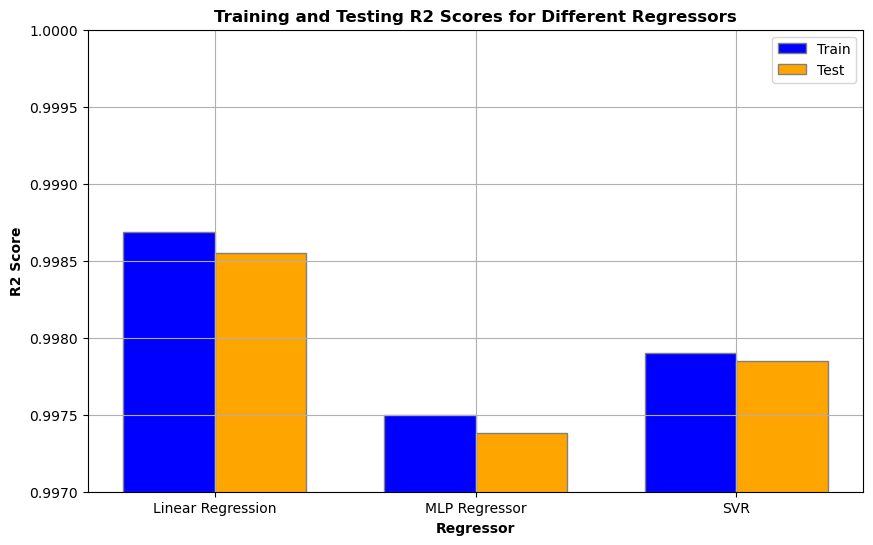

In [307]:
bar_width = 0.35

labels = ['Linear Regression', 'MLP Regressor', 'SVR']
train_r2 = [lrg_train_r2, mlr_train_r2, svr_train_r2]
test_r2 = [lrg_test_r2, mlr_test_r2, svr_test_r2]
axis1 = np.arange(len(labels))
axis2 = [x + bar_width for x in axis1]

plt.figure(figsize=(10, 6))
plt.bar(axis1, train_r2, color='blue', width=bar_width, edgecolor='grey', label='Train')
plt.bar(axis2, test_r2, color='orange', width=bar_width, edgecolor='grey', label='Test')

plt.ylim(0.997, 1)

plt.xlabel('Regressor', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(labels))], labels)
plt.ylabel('R2 Score', fontweight='bold')
plt.title('Training and Testing R2 Scores for Different Regressors', fontweight='bold')
plt.legend()

plt.grid(True)
plt.show()

Out of all the regressors and their parameters, linear regression stood out. It has the best score by far, but all models perform exceptionally well.
Additionally, all train scores are slightly better than the test scores, but they are so close together, it's safe to say there is no overfitting occurring.

Now let's compare test errors.

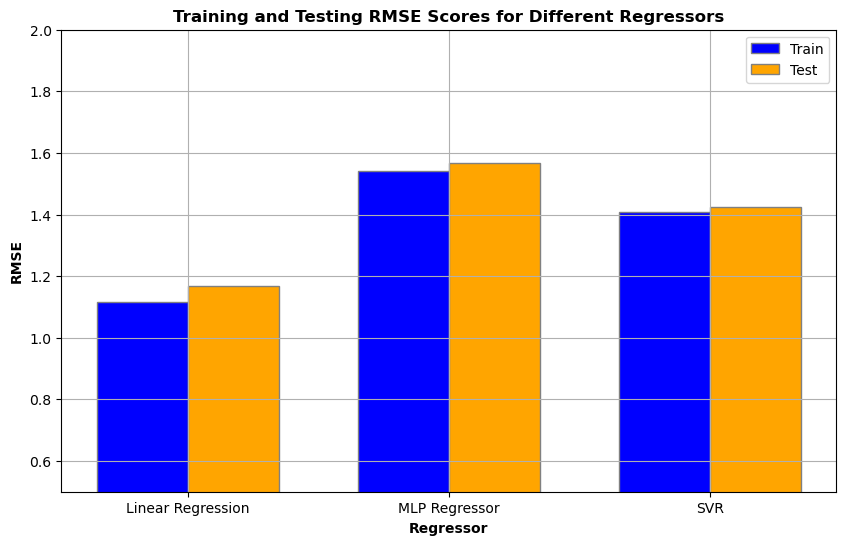

In [308]:
bar_width = 0.35

labels = ['Linear Regression', 'MLP Regressor', 'SVR']
train_rmse = [lrg_train_rmse, mlr_train_rmse, svr_train_rmse]
test_rmse = [lrg_test_rmse, mlr_test_rmse, svr_test_rmse]
axis1 = np.arange(len(labels))
axis2 = [x + bar_width for x in axis1]

plt.figure(figsize=(10, 6))
plt.bar(axis1, train_rmse, color='blue', width=bar_width, edgecolor='grey', label='Train')
plt.bar(axis2, test_rmse, color='orange', width=bar_width, edgecolor='grey', label='Test')

plt.ylim(0.5, 2.0)

plt.xlabel('Regressor', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(labels))], labels)
plt.ylabel('RMSE', fontweight='bold')
plt.title('Training and Testing RMSE Scores for Different Regressors', fontweight='bold')
plt.legend()

plt.grid(True)
plt.show()

These results follow the inverse trend of the r2 scores; mlp performs the worst and linear regression the best, but overall still very good results.

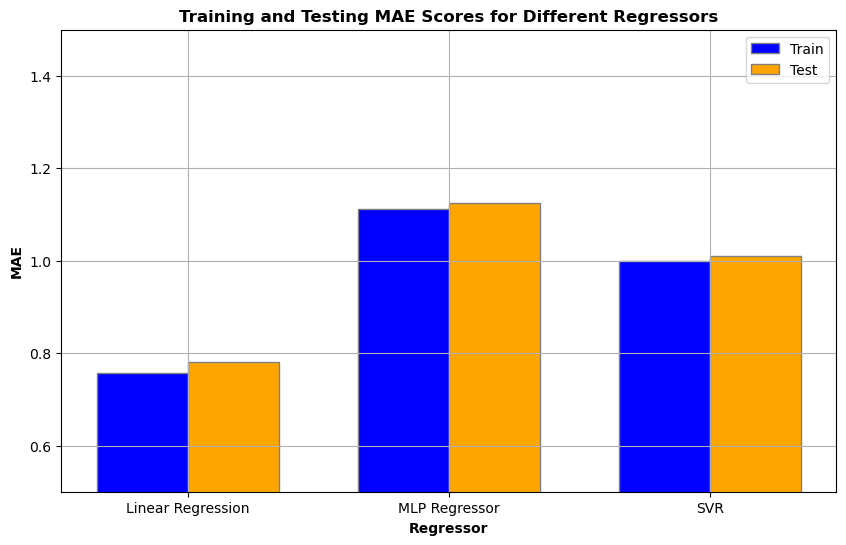

In [309]:
bar_width = 0.35

labels = ['Linear Regression', 'MLP Regressor', 'SVR']
train_mae = [lrg_train_mae, mlr_train_mae, svr_train_mae]
test_mae = [lrg_test_mae, mlr_test_mae, svr_test_mae]
axis1 = np.arange(len(labels))
axis2 = [x + bar_width for x in axis1]

plt.figure(figsize=(10, 6))
plt.bar(axis1, train_mae, color='blue', width=bar_width, edgecolor='grey', label='Train')
plt.bar(axis2, test_mae, color='orange', width=bar_width, edgecolor='grey', label='Test')

plt.ylim(0.5, 1.5)

plt.xlabel('Regressor', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(labels))], labels)
plt.ylabel('MAE', fontweight='bold')
plt.title('Training and Testing MAE Scores for Different Regressors', fontweight='bold')
plt.legend()

plt.grid(True)
plt.show()

Same trend as RMSE. Even with MLP performing the worst, our predictions would only be on average $1.13 off. It would be unlikely that it would cause us more losses than gains, so even the worst model performs excellently.

## References

- preprocessing date data: https://stackoverflow.com/questions/46428870/how-to-handle-date-variable-in-machine-learning-data-pre-processing
- offsetting date data algorithm (used to generate algorithm): chatGPT
- graph plotting (syntax help): chatGPT